In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
from tqdm import tqdm
import math
import random
device='cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-1-99092d766d13>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'cuda'

In [2]:
MODEL_NAME="google/vit-large-patch16-224-in21k"
BATCH_SIZE=64

In [3]:
root_dir=Path("/kaggle/input/crop-bird-dataset/crop_bird_dataset")

train_metadata_path = root_dir.parent/"train_metadata.csv"  # Path to the metadata file
train_images_dir = root_dir/"train/train/"       # Path to training images directory

val_metadata_path = root_dir.parent/"val_metadata.csv"      # Path to validation metadata file 
val_images_dir = root_dir/"val/val"           # Path to validation images directory

test_images_dir = root_dir/"test/test"

print(train_metadata_path)

/kaggle/input/crop-bird-dataset/train_metadata.csv


In [4]:
df_train = pd.read_csv(train_metadata_path)
df_train["path"] = train_images_dir/df_train["path"]
df_train["path"] = df_train["path"].apply(lambda path: train_images_dir/path.name)

df_val = pd.read_csv(val_metadata_path)
df_val["path"] = val_images_dir/df_val["path"]
df_val["path"] = df_val["path"].apply(lambda path: val_images_dir/path.name)

df_test = pd.DataFrame(
    data = {
    "path": [path for path in test_images_dir.glob("*.jpg")]
    }
)

df_train

,path,class,class_idx
0,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
1,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
2,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
3,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
4,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
...,...,...,...
1077,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1078,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1079,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1080,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3


<BarContainer object of 20 artists>

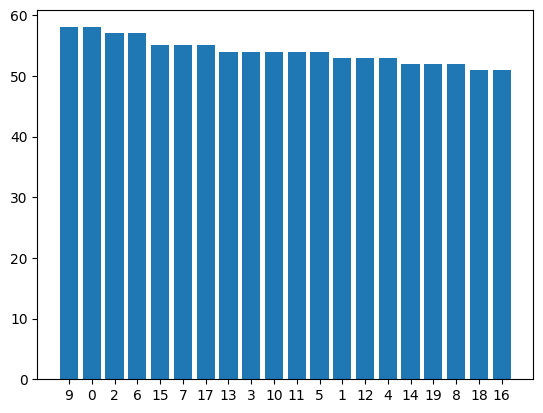

In [5]:
class_counts=df_train["class_idx"].value_counts()
plt.bar(class_counts.index.astype(str), class_counts)

In [6]:
class_counts=class_counts.sort_index()
class_weights=class_counts/class_counts.sum()
class_weights=torch.tensor(class_weights.to_numpy()).half().to(device)
class_weights

tensor([0.0536, 0.0490, 0.0527, 0.0499, 0.0490, 0.0499, 0.0527, 0.0508, 0.0481,
        0.0536, 0.0499, 0.0499, 0.0490, 0.0499, 0.0481, 0.0508, 0.0471, 0.0508,
        0.0471, 0.0481], device='cuda:0', dtype=torch.float16)

In [7]:
def read_image(path, transform=None):
    if not os.path.isfile(path):  # Check if file exists
        raise FileNotFoundError(f"Image not found: {path}")
    
    image = Image.open(path).convert("RGB")  # Open as RGB
    # image = torchvision.io.read_image(path)
    if transform:
        image = transform(image)  # Apply transformations
    return image

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

augmentation_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.v2.RandomResizedCrop(size=(224, 224), scale=(0.3,0.7)),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2, saturation=0.2, hue=0.0),
    transforms.RandomHorizontalFlip(),
    transforms.v2.RandomZoomOut(fill=0, side_range=(2.0, 4.0)),
    transforms.RandomRotation(90),
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half(),
    # transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half()
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [8]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, imgs_labels=None, transform=None, mixup=False, num_classes=20):
        super().__init__()
        self.imgs_paths = imgs_paths
        self.imgs_labels = imgs_labels
        self.transform = transform
        self.mixup=mixup
        self.alpha_mixup=0.2
        self.num_classes=num_classes

    def __getitem__(self, idx):
        #print(f"Loading image: {self.imgs_paths.iloc[idx]}") 
        image = read_image(self.imgs_paths.iloc[idx], self.transform)
        if self.imgs_labels is None:
            return image
        else:
            label = self.imgs_labels.iloc[idx]
            return image, label

    def __getitems__(self, indices):
        images=self.imgs_paths.iloc[indices].apply(lambda path: read_image(path, self.transform))
        
        if self.mixup==True:
            alpha_mixup=0.4
            images=torch.stack(images.to_list())
            mixup_indices=np.random.randint(low=0, high=len(self.imgs_paths), size=len(indices))
            mixup_images=self.imgs_paths.iloc[mixup_indices].apply(lambda path: read_image(path, self.transform))
            mixup_images=torch.stack(mixup_images.to_list())
            labels = self.imgs_labels.iloc[indices]
            labels = F.one_hot(torch.tensor(labels.to_numpy()), num_classes=self.num_classes)
            mixup_labels=torch.tensor(self.imgs_labels.iloc[mixup_indices].to_list())
            mixup_labels=F.one_hot(mixup_labels, num_classes=self.num_classes)
            lambdas = torch.tensor(np.random.beta(alpha_mixup,alpha_mixup, size=len(indices)))
            # print(lambdas.shape, images.shape, mixup_images.shape)
            final_images=lambdas.reshape(-1,1,1,1)*images+(1-lambdas.reshape(-1,1,1,1))*mixup_images
            final_labels=lambdas.reshape(-1,1)*labels+(1-lambdas.reshape(-1,1))*mixup_labels
            return [final_image for final_image in final_images], final_labels
        else:     
            if self.imgs_labels is None:
                return images.to_list()
            else:
                labels = self.imgs_labels.iloc[indices]
                return images.to_list(), labels.to_list()

    def __len__(self):
        return len(self.imgs_paths)

In [9]:
train_dataset = BirdDataset(imgs_paths = df_train["path"], imgs_labels = df_train["class_idx"], transform = augmentation_transform, mixup=True)
print(f"train loaded {len(train_dataset)}")
val_dataset = BirdDataset(imgs_paths = df_val["path"], imgs_labels = df_val["class_idx"], transform = transform)
print(f"val loaded {len(val_dataset)}")
test_dataset = BirdDataset(imgs_paths = df_test["path"], transform = transform)
print(f"test loaded {len(test_dataset)}")

train loaded 1082
val loaded 103
test loaded 400


In [10]:
def collate_function(batch):
    if len(batch)==2:
        x, y = batch
        if not torch.is_tensor(y):
            y = torch.tensor(y)
        return torch.stack(x), y
    else:
        return torch.stack(batch)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 4, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)

tensor([0.0000, 0.0000, 0.0927, 0.9073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], dtype=torch.float64)


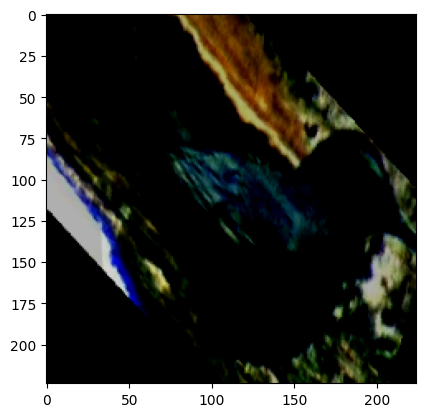

In [12]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0).float())
print(labels[0])

In [13]:
num_classes = df_train["class_idx"].nunique()
print(f"num_classes = {num_classes}")

num_classes = 20


In [14]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        # self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit = ViTModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        hidden = self.vit(pixel_values=x)
        cls_token = hidden.last_hidden_state[:, 0]
        return self.classifier(cls_token)

model = ViTClassifier(num_classes).to(device)
model=model.half()

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [15]:
def accuracy_fn(logits, labels):
    y_probs=F.softmax(logits, dim=-1)
    y_preds=y_probs.argmax(dim=-1)
    accuracy=(y_preds==labels).sum()/len(labels)
    return accuracy

In [16]:
num_classes = 20

In [17]:
num_epochs = 100
max_lr=1e-5

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=max_lr, eps=1e-04)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

accuracies_g=[]
train_losses_g=[]
val_losses_g=[]
best_validation=1e9


for epoch in range(num_epochs):
    
    model.train()
    accuracies = []
    train_losses = []
    val_losses = []

    for batch, labels in tqdm(train_loader):
        
        batch, labels = batch.to(device), labels.to(device)
        logits = model(batch)
        
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(val_loader):
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)
            loss = criterion(logits, labels)
            accuracy = accuracy_fn(logits, labels)

            accuracies.append(accuracy.item())
            val_losses.append(loss.item())

    
    accuracies_g.append(torch.tensor(accuracies).mean().item())
    train_losses_g.append(torch.tensor(train_losses).mean().item())
    val_losses_g.append(torch.tensor(val_losses).mean().item())
    print(f"Epoch: {epoch}, train_loss: {train_losses_g[-1]}, val_loss: {val_losses_g[-1]}, accuracy: {accuracies_g[-1]}")
    
    if best_validation>val_losses_g[-1]:
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        best_validation=val_losses_g[-1]

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Epoch: 0, train_loss: 0.15298353135585785, val_loss: 3.1044921875, accuracy: 0.0078125


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 1, train_loss: 0.1525471955537796, val_loss: 3.1025390625, accuracy: 0.0078125


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 2, train_loss: 0.15241140127182007, val_loss: 3.099609375, accuracy: 0.0078125


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 3, train_loss: 0.15251143276691437, val_loss: 3.09375, accuracy: 0.015625


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 4, train_loss: 0.15308207273483276, val_loss: 3.083984375, accuracy: 0.015625


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Epoch: 5, train_loss: 0.15167748928070068, val_loss: 3.068359375, accuracy: 0.0234375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 6, train_loss: 0.15174227952957153, val_loss: 3.0478515625, accuracy: 0.0390625


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 7, train_loss: 0.150904580950737, val_loss: 3.0205078125, accuracy: 0.0546875


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 8, train_loss: 0.1504526138305664, val_loss: 2.98828125, accuracy: 0.0625


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 9, train_loss: 0.14882032573223114, val_loss: 2.9482421875, accuracy: 0.12439903616905212


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 10, train_loss: 0.14798927307128906, val_loss: 2.9013671875, accuracy: 0.24539263546466827


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 11, train_loss: 0.14682115614414215, val_loss: 2.8466796875, accuracy: 0.2838541865348816


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 12, train_loss: 0.14449459314346313, val_loss: 2.7880859375, accuracy: 0.36919069290161133


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 13, train_loss: 0.14362898468971252, val_loss: 2.72265625, accuracy: 0.43890225887298584


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 14, train_loss: 0.14148496091365814, val_loss: 2.6533203125, accuracy: 0.5214343070983887


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 15, train_loss: 0.13961297273635864, val_loss: 2.576171875, accuracy: 0.6089743375778198


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 16, train_loss: 0.13787433505058289, val_loss: 2.4951171875, accuracy: 0.7199519276618958


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 17, train_loss: 0.13486628234386444, val_loss: 2.41015625, accuracy: 0.7277644276618958


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 18, train_loss: 0.1336648315191269, val_loss: 2.3173828125, accuracy: 0.7355769276618958


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 19, train_loss: 0.13055197894573212, val_loss: 2.2197265625, accuracy: 0.7305688858032227


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 20, train_loss: 0.12734106183052063, val_loss: 2.123046875, accuracy: 0.7512019276618958


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch: 21, train_loss: 0.1246880516409874, val_loss: 2.0263671875, accuracy: 0.8080929517745972


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 22, train_loss: 0.12144799530506134, val_loss: 1.91650390625, accuracy: 0.8002804517745972


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 23, train_loss: 0.11810285598039627, val_loss: 1.81884765625, accuracy: 0.8237179517745972


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 24, train_loss: 0.11371729522943497, val_loss: 1.71630859375, accuracy: 0.8393429517745972


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 25, train_loss: 0.1100965291261673, val_loss: 1.61083984375, accuracy: 0.8705929517745972


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 26, train_loss: 0.10455786436796188, val_loss: 1.513671875, accuracy: 0.8862179517745972


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 27, train_loss: 0.10486476123332977, val_loss: 1.41845703125, accuracy: 0.9146634340286255


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 28, train_loss: 0.10085029900074005, val_loss: 1.32763671875, accuracy: 0.9274839758872986


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 29, train_loss: 0.0969640389084816, val_loss: 1.24072265625, accuracy: 0.9481170177459717


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 30, train_loss: 0.09286686033010483, val_loss: 1.15673828125, accuracy: 0.9403045177459717


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 31, train_loss: 0.09088723361492157, val_loss: 1.087646484375, accuracy: 0.9403045177459717


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 32, train_loss: 0.08828004449605942, val_loss: 1.025390625, accuracy: 0.9375


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Epoch: 33, train_loss: 0.08512821048498154, val_loss: 0.967041015625, accuracy: 0.9375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 34, train_loss: 0.08412877470254898, val_loss: 0.915771484375, accuracy: 0.9375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 35, train_loss: 0.0837680995464325, val_loss: 0.873046875, accuracy: 0.9453125


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 36, train_loss: 0.07867345213890076, val_loss: 0.831787109375, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 37, train_loss: 0.07941471040248871, val_loss: 0.796630859375, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 38, train_loss: 0.08045611530542374, val_loss: 0.765625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 39, train_loss: 0.08074922859668732, val_loss: 0.7333984375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 40, train_loss: 0.07802170515060425, val_loss: 0.706787109375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 41, train_loss: 0.07691949605941772, val_loss: 0.68212890625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 42, train_loss: 0.07593512535095215, val_loss: 0.655517578125, accuracy: 0.96875


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 43, train_loss: 0.07410305738449097, val_loss: 0.63623046875, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Epoch: 44, train_loss: 0.07316970080137253, val_loss: 0.62060546875, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 45, train_loss: 0.07426648586988449, val_loss: 0.60595703125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 46, train_loss: 0.07262368500232697, val_loss: 0.595947265625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 47, train_loss: 0.07259339094161987, val_loss: 0.58935546875, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 48, train_loss: 0.0709085762500763, val_loss: 0.572509765625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 49, train_loss: 0.07221464067697525, val_loss: 0.563232421875, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 50, train_loss: 0.07122846692800522, val_loss: 0.5538330078125, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 51, train_loss: 0.0705815926194191, val_loss: 0.5513916015625, accuracy: 0.9453125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 52, train_loss: 0.07091949880123138, val_loss: 0.5404052734375, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 53, train_loss: 0.07161794602870941, val_loss: 0.532958984375, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 54, train_loss: 0.06740075349807739, val_loss: 0.5228271484375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 55, train_loss: 0.0696105808019638, val_loss: 0.515625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 56, train_loss: 0.07226801663637161, val_loss: 0.512451171875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 57, train_loss: 0.06966037303209305, val_loss: 0.5087890625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 58, train_loss: 0.07043124735355377, val_loss: 0.5052490234375, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 59, train_loss: 0.06805814057588577, val_loss: 0.500244140625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 60, train_loss: 0.06682264804840088, val_loss: 0.4931640625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 61, train_loss: 0.06817690283060074, val_loss: 0.4908447265625, accuracy: 0.9453125


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 62, train_loss: 0.06897547096014023, val_loss: 0.490966796875, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 63, train_loss: 0.0686333179473877, val_loss: 0.4901123046875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 64, train_loss: 0.06910889595746994, val_loss: 0.48828125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 65, train_loss: 0.0676717534661293, val_loss: 0.4852294921875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 66, train_loss: 0.06918805837631226, val_loss: 0.4833984375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 67, train_loss: 0.06935527175664902, val_loss: 0.4814453125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 68, train_loss: 0.06949391216039658, val_loss: 0.4801025390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Epoch: 69, train_loss: 0.07041656225919724, val_loss: 0.47802734375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 70, train_loss: 0.06938475370407104, val_loss: 0.4771728515625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 71, train_loss: 0.06941759586334229, val_loss: 0.47705078125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 72, train_loss: 0.06758151203393936, val_loss: 0.4774169921875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 73, train_loss: 0.06946151703596115, val_loss: 0.4766845703125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 74, train_loss: 0.06931883096694946, val_loss: 0.4755859375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 75, train_loss: 0.06701483577489853, val_loss: 0.4747314453125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch: 76, train_loss: 0.06977378576993942, val_loss: 0.473876953125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 77, train_loss: 0.06668273359537125, val_loss: 0.4739990234375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 78, train_loss: 0.06875960528850555, val_loss: 0.473876953125, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 79, train_loss: 0.06709706038236618, val_loss: 0.473388671875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 80, train_loss: 0.06764522194862366, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 81, train_loss: 0.06978296488523483, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 82, train_loss: 0.0702054500579834, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 83, train_loss: 0.06854851543903351, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 84, train_loss: 0.069188691675663, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 85, train_loss: 0.06904793530702591, val_loss: 0.473388671875, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Epoch: 86, train_loss: 0.06694971770048141, val_loss: 0.4732666015625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 87, train_loss: 0.06819234788417816, val_loss: 0.4732666015625, accuracy: 0.953125


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 88, train_loss: 0.06781924515962601, val_loss: 0.4732666015625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 89, train_loss: 0.0698947161436081, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 90, train_loss: 0.06641591340303421, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 91, train_loss: 0.06872951239347458, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Epoch: 92, train_loss: 0.06813756376504898, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Epoch: 93, train_loss: 0.06811317801475525, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 94, train_loss: 0.06877484172582626, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch: 95, train_loss: 0.06886374950408936, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 96, train_loss: 0.0669969916343689, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch: 97, train_loss: 0.06990323215723038, val_loss: 0.472900390625, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch: 98, train_loss: 0.0676698386669159, val_loss: 0.4730224609375, accuracy: 0.9609375


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Epoch: 99, train_loss: 0.06718277186155319, val_loss: 0.4730224609375, accuracy: 0.9609375


In [18]:
model.load_state_dict(torch.load('/kaggle/working/model.pt', weights_only=True))

<All keys matched successfully>

In [19]:
all_preds=[]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        logits = model(batch)
        y_probs=F.softmax(logits, dim=-1)
        y_preds=y_probs.argmax(dim=-1)
        all_preds.append(y_preds)

all_preds=torch.cat(all_preds)

100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


In [20]:
df_submit=df_test.copy()
df_submit["class_idx"]=all_preds.cpu().numpy()
df_submit["path"]=df_submit["path"].apply(lambda path: Path(path).name)
df_submit.to_csv("vit_model_large_half_smooth_labels_augmentation1.csv",index=False)
df_submit

,path,class_idx
0,e17fb45d-08a6-412a-8436-c68bca97a2b0.jpg,11
1,da82c136-bbca-4f69-9e97-2c0edf75e223.jpg,7
2,beb3a70d-c13f-47aa-aaed-2834488a2665.jpg,12
3,2c25579e-d68d-46fa-a6fe-35dc7b5ddbda.jpg,17
4,8ba3fd3a-09b1-40f2-9d64-e3e6c61c7c3b.jpg,15
...,...,...
395,30b4b83f-1559-464f-a729-cf8679f73077.jpg,11
396,4989cca6-982c-4f7d-a531-50334a3dd5b3.jpg,19
397,860a92e8-8c06-4e38-83d4-05d07d0baacf.jpg,0
398,1d9c405f-b193-4034-9744-1ce5c2778296.jpg,1
